In [1]:
!git pull

Already up-to-date.


In [2]:
import os
os.environ['RAY_LOG_LEVEL'] = "DEBUG"

In [3]:
import ray
import json
import pickle
import mlflow
import tqdm
import torch
from os import path
from utils import check_path, convert_np_arrays, flatten_dict
from gymnasium.wrappers import TimeLimit
from dynaconf import Dynaconf
from ray.rllib.models import ModelCatalog
from environments.MutilRoadEnv import RouteEnv
from ray.tune.registry import register_env
from ray.rllib.algorithms.apex_dqn import ApexDQN, ApexDQNConfig
from ray.rllib.algorithms.dqn import DQN, DQNConfig
from ray.tune.logger import JsonLogger
from algorithms.apex_ddqn import ApexDDQNWithDPBER
from replay_buffer.mpber import MultiAgentPrioritizedBlockReplayBuffer
from environments.ObsWrapper import FullRGBImgPartialObsWrapper, RGBImgPartialObsWrapper
from func_timeout import FunctionTimedOut
from mlflow.exceptions import MlflowException
from model.image_decoder import CustomCNN
from minigrid.wrappers import ImgObsWrapper
import gymnasium as gym

pygame 2.5.2 (SDL 2.28.2, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


2023-12-06 09:21:40,668	WARNING __init__.py:10 -- ApexDQN has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.


In [4]:
torch.cuda.is_available()

True

In [5]:
# Init Ray
ray.init(
    num_cpus=16, num_gpus=1,
    include_dashboard=True,
    _system_config={"maximum_gcs_destroyed_actor_cached_count": 200},
)


2023-12-06 09:21:42,834	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.18
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [6]:
# Config path
log_path = "./logs/"
checkpoint_path = "./checkpoints"
setting = Dynaconf(envvar_prefix="DYNACONF", settings_files="./apex.yml")

# Set hyper parameters
hyper_parameters = setting.hyper_parameters.to_dict()
hyper_parameters["logger_config"] = {"type": JsonLogger, "logdir": checkpoint_path}
print("log path: %s \ncheck_path: %s" % (log_path, checkpoint_path))

log path: ./logs/ 
check_path: ./checkpoints


In [7]:
hyper_parameters["env_config"] = {
        "size": 20,
        "roads": (5, 7),
        "max_steps": 1000,
        "battery":100,
        "render_mode": "rgb_array",
        "agent_pov": False
    }

In [8]:
# Set MLflow
mlflow.set_tracking_uri(setting.mlflow.url)
mlflow.set_experiment(experiment_name=setting.mlflow.experiment)
mlflow_client = mlflow.tracking.MlflowClient()

In [9]:
# Test Env

# Build env
def env_creator(env_config):
    env = gym.make("MiniGrid-ObstructedMaze-Full-v1", render_mode="rgb_array")
    # env = RouteEnv(**env_config)
    # env = FullRGBImgPartialObsWrapper(env, tile_size=5)
    env = RGBImgPartialObsWrapper(env, tile_size=10)
#     env = TimeLimit(env, max_episode_steps=1000)
    return ImgObsWrapper(env)

register_env("RandomPath", env_creator)

env = env_creator(hyper_parameters["env_config"])
obs, _ = env.reset()
step = env.step(1)
print(env.action_space, env.observation_space)

Discrete(7) Box(0, 255, (70, 70, 3), uint8)


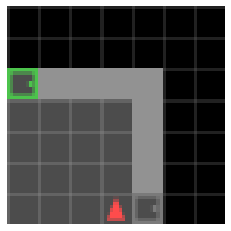

In [10]:
import matplotlib.pyplot as plt

plt.imshow(obs)
plt.axis('off')
plt.show()

In [11]:
run_name = "ObstructedMaze DPBER"
mlflow_run = mlflow.start_run(run_name=run_name,
                              tags={"mlflow.user": setting.mlflow.user})

In [12]:
ModelCatalog.register_custom_model("CustomCNN", CustomCNN)

hyper_parameters["model"] = {
        "custom_model": "CustomCNN",
        "no_final_linear": True,
        "fcnet_hiddens": hyper_parameters["hiddens"],
        "custom_model_config": {},
    }

In [13]:
# Set BER
sub_buffer_size = hyper_parameters["rollout_fragment_length"]
replay_buffer_config = {
    **hyper_parameters["replay_buffer_config"],
    "type": MultiAgentPrioritizedBlockReplayBuffer,
    "capacity": int(hyper_parameters["replay_buffer_config"]["capacity"]),
    "obs_space": env.observation_space,
    "action_space": env.action_space,
    "sub_buffer_size": sub_buffer_size,
    "worker_side_prioritization": False,
    "replay_buffer_shards_colocated_with_driver": True,
    "rollout_fragment_length": hyper_parameters["rollout_fragment_length"]
}
hyper_parameters["replay_buffer_config"] = replay_buffer_config
hyper_parameters["train_batch_size"] = int(hyper_parameters["train_batch_size"] / sub_buffer_size)
trainer = ApexDDQNWithDPBER(config=hyper_parameters, env="RandomPath")

2023-12-06 09:21:43,725	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/apex_dqn/` has been deprecated. Use `rllib_contrib/apex_dqn/` instead. This will raise an error in the future!
2023-12-06 09:21:43,726	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
2023-12-06 09:21:43,726	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='RandomPath', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('RandomPath').build()` instead. This will raise an error in the future!
/home/seventheli/miniconda3/envs/drone/lib/python3.9/site-packages/ray/rllib/utils/from_config.py:197: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of th

In [14]:
for i in hyper_parameters["resources"]:
    hyper_parameters[i] = hyper_parameters["resources"][i]

In [15]:
# Log parameters
mlflow.log_params(hyper_parameters["replay_buffer_config"])
to_log = ['double_q', 'dueling', 'noisy', 'adam_epsilon', 'lr', 'n_step', 'num_atoms', 'num_steps_sampled_before_learning_starts',
          'rollout_fragment_length', 'target_network_update_freq', 'train_batch_size', 'min_sample_timesteps_per_iteration']
mlflow.log_params(
    {key: hyper_parameters[key] for key in to_log})

In [16]:
# Check path available
check_path(log_path)
log_path = path.join(log_path, run_name)
check_path(log_path)
check_path(checkpoint_path)
checkpoint_path = path.join(checkpoint_path, run_name)
check_path(checkpoint_path)

with open(os.path.join(checkpoint_path, "%s_config.pyl" % run_name), "wb") as f:
    pickle.dump(trainer.config.to_dict(), f)

checkpoint_path = path.join(checkpoint_path, "results")
check_path(checkpoint_path)
mlflow.log_artifacts(checkpoint_path)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [17]:
# Run algorithms
keys_to_extract_sam = {"episode_reward_max", "episode_reward_min", "episode_reward_mean"}
keys_to_extract_sta = {"num_agent_steps_sampled", "num_agent_steps_trained", "episode_reward_mean"}
keys_to_extract_buf = {"add_batch_time_ms", "replay_time_ms", "update_priorities_time_ms"}

In [ ]:
for i in tqdm.tqdm(range(1, 2000)):
    result = trainer.train()
    try:
        result = trainer.train()
        time_used = result["time_total_s"]
    except:
        continue
    try:
        if i >= setting.log.log and i % setting.log.log == 0:
            sampler = result.get("sampler_results", {}).copy()
            info = result.get("info", {}).copy()
            sam = {key: sampler[key] for key in keys_to_extract_sam if key in sampler}
            sta = {key: info[key] for key in keys_to_extract_sta if key in info}
            buf = flatten_dict(info.get("replay_shard_0", {}))
            lea = info.get("learner", {}).get("time_usage", {})
            mlflow.log_metrics({**sam, **sta, **buf, **lea}, step=result["episodes_total"])
            trainer.save_checkpoint(checkpoint_path)
        if i % (setting.log.log * 100) == 0:
            mlflow.log_artifacts(log_path)
            mlflow.log_artifacts(checkpoint_path)
    except FunctionTimedOut:
        tqdm.tqdm.write("logging failed")
    except MlflowException:
        tqdm.tqdm.write("logging failed")
    with open(path.join(log_path, str(i) + ".json"), "w") as f:
        result["config"] = None
        json.dump(convert_np_arrays(result), f)
    if time_used >= setting.log.max_time:
        break

  0%|          | 0/1999 [00:00<?, ?it/s](RolloutWorker pid=2549404) INFO:root:cpu
(RolloutWorker pid=2549404) INFO:root:cpu
(RolloutWorker pid=2549404) INFO:root:cpu
(RolloutWorker pid=2549404) INFO:root:cpu
(MultiAgentPrioritizedBlockReplayBuffer pid=2549889) 2023-12-06 09:21:51,899	WARNING multi_agent_prioritized_replay_buffer.py:215 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
(RolloutWorker pid=2549404) INFO:root:cpu [repeated 11430x across cluster]
(MultiAgentPrioritizedBlockReplayBuffer pid=2549888) 2023-12-06 09:21:51,938	WARNING multi_agent_prioritized_replay_buffer.py:215 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten. [repeated 3x across cluster]
INFO:root:cuda:0
INFO:root:cuda:0
INFO:root:cuda:0
INFO:root:cuda:0
INFO:root:cuda:0
INFO:root:cuda:0
INFO:root:cu